# 2.2 - Ajuste Supervisado

### GridSearching  -  CrossValidation


![grid](images/grid.png)

![cv](images/cv.ppm)

In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np


from sklearn.datasets import make_circles, make_regression

from sklearn.model_selection import train_test_split as tts

from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as RFC

from sklearn.model_selection import GridSearchCV        # por fuerza bruta
from sklearn.model_selection import RandomizedSearchCV

In [4]:
#help(RFR)

In [35]:
def grid(modelo, param):

    g = GridSearchCV(modelo,   # modelo de sklearn
                     param,    # diccionario de parametros
                     cv=5,     # nº de cortes
                     return_train_score=True, # error en entrenamiento para checkear
                     n_jobs=-1  # usa todos los nucleos disponibles
                     )

    g.fit(X_train, y_train)

    print('Acierto test: {:.2f}'.format(g.score(X_test, y_test)))
    print('Acierto train: {:.2f}'.format(g.score(X_train, y_train)))
    print('Mejores parametros: {}'.format(g.best_params_))
    print('Mejor acierto cv: {:.2f}'.format(g.best_score_))


    return g.best_estimator_.fit(X_train, y_train)

In [31]:
X = make_regression()[0]

y = make_regression()[1]


X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

In [32]:
%%time

rfr=RFR()

rfr.fit(X_train, y_train)

# R2
train_score=rfr.score(X_train, y_train)
test_score=rfr.score(X_test, y_test)

print (train_score, test_score)

0.8520772054687626 0.07964942318518953
CPU times: user 178 ms, sys: 1.58 ms, total: 179 ms
Wall time: 178 ms


In [33]:
param={'n_estimators': [10, 50, 100, 150, 200, 500],
       'max_depth': [1, 5, 10, 15, 20]}

In [36]:
%%time

modelo_grid = grid(RFR(), param)

Acierto test: 0.12
Acierto train: 0.84
Mejores parametros: {'max_depth': 5, 'n_estimators': 50}
Mejor acierto cv: -0.10
CPU times: user 249 ms, sys: 16.3 ms, total: 265 ms
Wall time: 6.38 s


In [38]:
modelo_grid.score(X_train, y_train)

0.8071224594501535

In [39]:
modelo_grid.score(X_test, y_test)

0.05860998657072114

### Random GridSearching

In [46]:
X, y = make_circles(noise=0.1, factor=0.5, random_state=1)

In [47]:
y[:10]

array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1])

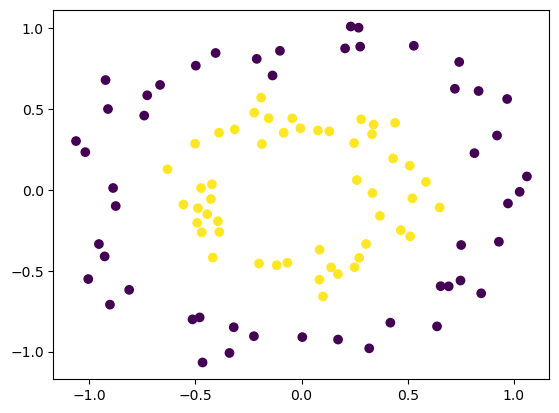

In [48]:
import pylab as plt

plt.scatter(X[::, 0], X[::, 1], c=y);

In [49]:
n_estimators=[int(x) for x in np.linspace(200, 2000, 10)]

max_features=['sqrt']

min_samples_split=[2, 5, 10]

bootstrap=[True, False]

In [50]:
params={'n_estimators': n_estimators,
        'max_features': max_features,
        'min_samples_split':min_samples_split,
        'bootstrap': bootstrap}

In [51]:
rfc=RFC()

In [52]:
rf_random = RandomizedSearchCV(estimator=rfc,
                               param_distributions=params,
                               n_iter=200,
                               cv=3,
                               verbose=10,
                               n_jobs=-1,
                               scoring='roc_auc'
                              )

In [53]:
rf_random.fit(X, y)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='roc_auc', verbose=10)

In [54]:
rf_random.best_estimator_.fit(X, y)

RandomForestClassifier(bootstrap=False, n_estimators=200)

In [55]:
rf_random.best_score_

1.0

In [56]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'max_features': 'sqrt',
 'bootstrap': False}

### HyperOpt (GridSearching bayesiano)

In [ ]:
%pip install hyperopt

In [57]:
import pandas as pd

import xgboost as xgb

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as tts

In [58]:
df=pd.read_csv('../data/diamonds_train.csv')
df=df.dropna()
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95


In [59]:
clarity={'I1':0, 'SI2':1, 'SI1':2, 'VS2':3, 'VS1':4,
         'VVS2':5, 'VVS1':6, 'IF':7}


cut={'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4}


color={'J':0, 'I':1, 'H':2, 'G':3, 'F':4, 'E':5, 'D':6}

In [60]:
X=df.drop('price', axis=1)

y=df.price

In [61]:
def label(s, dic):
    return dic[s]

In [62]:
X.clarity=X.clarity.apply(lambda x: label(x, clarity))

X.cut=X.cut.apply(lambda x: label(x, cut))

X.color=X.color.apply(lambda x: label(x, color))

X.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,1.21,3,0,3,62.4,58.0,6.83,6.79,4.25
1,0.32,2,2,3,63.0,57.0,4.35,4.38,2.75
2,0.71,0,3,4,65.5,55.0,5.62,5.53,3.65
3,0.41,1,6,2,63.8,56.0,4.68,4.72,3.00
4,1.02,4,3,2,60.5,59.0,6.55,6.51,3.95


In [63]:
X_train, X_test, y_train, y_test = tts(X, y, 
                                       test_size=0.2, 
                                       random_state=42)

In [64]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32364, 9), (8091, 9), (32364,), (8091,))

In [67]:
modelo = xgb.XGBRegressor()

modelo.fit(X_train, y_train)

y_pred=modelo.predict(X_test)

mse(y_test, y_pred, squared=False)   # RMSE

546.2492119850257

In [69]:
#modelo

In [77]:
#help(RFC())

In [70]:
# aprioris

space={
    
    'n_estimators': hp.quniform('n_estimators', 10, 1000, 25),  # distribucion uniforme discreta
    
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1.0),  # distribucion uniforme continua
    
    'max_depth': hp.quniform('max_depth', 4, 16, 1),
    
    'min_child_weight': hp.quniform('min_child', 1, 10, 1),
    
    'subsample': hp.uniform('subsample', 0.7, 1),
    
    'gamma': hp.uniform('gamma', 0.1, 0.5),
    
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

In [71]:
def objetivo(space):

    modelo=xgb.XGBRegressor(

            n_estimators=int(space['n_estimators']),
            learning_rate=space['learning_rate'],
            max_depth=int(space['max_depth']),
            min_child_weight=space['min_child_weight'],
            subsample=space['subsample'],
            gamma=space['gamma'],
            reg_lambda=space['reg_lambda'],
            objective='reg:squarederror'
        )

    eval_set=[(X_train, y_train), (X_test, y_test)]

    modelo.fit(X_train, y_train, eval_set=eval_set, eval_metric='rmse', verbose=False)

    y_pred=modelo.predict(X_test)

    rmse=mse(y_test, y_pred, squared=False)
    
    return {'loss': rmse, 'status': STATUS_OK}


In [72]:
best = fmin(fn=objetivo,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=Trials())

best

100%|████████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.24s/trial, best loss: 537.4931988553552]


{'gamma': 0.10350566709484572,
 'learning_rate': 0.09723978162728081,
 'max_depth': 6.0,
 'min_child': 5.0,
 'n_estimators': 850.0,
 'reg_lambda': 0.5387400694181826,
 'subsample': 0.9599978987751512}

In [73]:
modelo=xgb.XGBRegressor(
    n_estimators=int(best['n_estimators']),
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    subsample=best['subsample'],
    gamma=best['gamma'],
    reg_lambda=best['reg_lambda'],
    objective='reg:squarederror'
    )

In [74]:
modelo.fit(X_train, y_train)

y_pred=modelo.predict(X_test)

mse(y_test, y_pred, squared=False)

540.0939852370989

In [75]:
m=xgb.XGBRegressor()
m.fit(X_train, y_train)
y_pred=m.predict(X_test)

mse(y_test, y_pred, squared=False)

546.2492119850257